In [198]:
from rich.jupyter import display
%pip install pandas numpy spacy matplotlib plotly scikit-learn beautifulsoup4 nltk

Note: you may need to restart the kernel to use updated packages.


In [199]:
%pip install bertopic top2vec fastopic lda

Note: you may need to restart the kernel to use updated packages.


In [200]:
!python -m spacy download es_core_news_sm

     ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
     ------------------------------- ------- 10.5/12.9 MB 81.8 MB/s eta 0:00:01
     ---------------------------------------- 12.9/12.9 MB 53.7 MB/s  0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


In [201]:
import os
import re

import numpy as np
import pandas as pd
import spacy
from bs4 import BeautifulSoup

## Extraccion de datos
Para la realizacion de este prototipo utilizaremos como set de datos varios ficheros correspondientes a los README.md de diversos TFG de años anteriores. Estos ficheros se encontrarán en la carpeta `prototypes/data`.

Luego de la carga de datos se procedera a la limpieza de los mismos eliminando palabras que no aporten significado (stopword) y signos de puntuacion de las cadenas, todo esto con el fin de tener un conjunto de datos más representativo.

In [202]:
data_folder = "data/"

raw_documents = [] #array para almacenar todos los documentos
docs_names =  []

for filename in os.listdir(data_folder):
    with open(os.path.join(data_folder, filename), "r", encoding="utf-8") as f:
        text = f.read()
        raw_documents.append(text.strip())
        docs_names.append(filename)
print(f"Number of documents: {len(raw_documents)}")

Number of documents: 7


In [203]:
df_raw_docs = pd.DataFrame({
    "nombre": docs_names,
    "texto": raw_documents
})
df_raw_docs["num_palabras"] = df_raw_docs["texto"].apply(lambda x: len(x.split()))
print(df_raw_docs.shape)
df_raw_docs.head()

(7, 3)


,nombre,texto,num_palabras
0,EcoCityTours.md,# Eco City Tours\n\n## TFG Ingeniería Informát...,624
1,FF1nalLap.md,"<h1 align=""center""> 🏁 F1nalLap 🏎️ </h1>\n\n## ...",230
2,GCA.md,# GCA \n![license](https://img.shields.io/bad...,187
3,gestionFormacion.md,# Gestión de Formación\n\n![PHPUnit](https://g...,642
4,graphqlstore.md,"[<p align=""center""><img src=""./graphqlstore.p...",2724


In [204]:
import nltk

# Descargar stopwords (solo la primera vez)
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zeldan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [205]:
from nltk.corpus import stopwords

stop_words_sp = set(stopwords.words('spanish'))
stop_words_en = set(stopwords.words('english'))

#unión de ambas listas
STOPWORDS_ALL = stop_words_sp.union(stop_words_en)
print(list(STOPWORDS_ALL)[:15]) # mostramos solo las 15 primeras palabas como ejemplo


['quien', "she's", 'tenéis', 'until', 'mías', "i'm", 'antes', 'tiene', 'él', 'será', 'that', 'hubisteis', 'habrías', 'once', 'estáis']


In [206]:
def remove_html(_text):
    no_html_txt = BeautifulSoup(_text, "html.parser").getText(separator=" ")
    return no_html_txt

def clear_text(_text):
    #Eliminar etiquetas html
    _text = remove_html(_text)

    # Limpieza basica del texto
    ## Eliminar bloques de código entre ```
    _text = re.sub(r"```.*?```", " ", _text, flags=re.DOTALL)

    ##Eliminar etiquetas markdown (#, *, _, >, etc.)
    _text = re.sub(r"[#*_>\-`~]", " ", _text)

    ##Eliminar URLs y direcciones tipo http o www
    _text = re.sub(r"http\S+|www\S+", " ", _text)

    ##Eliminar etiquetas HTML o imágenes ![texto](url)
    _text = re.sub(r"!\[.*?\]\(.*?\)", " ", _text)

    ##quitar números y caracteres no alfabéticos (mantener letras acentuadas)
    texto = re.sub(r"[^a-zA-ZáéíóúñÁÉÍÓÚüÜ\s]", " ", _text)

    ##texto a minusculas para hacer mejores comparaciones
    _text = _text.lower()

    # Eliminacion de stopwords
    ## Cargar modelo de spaCy en español
    nlp = spacy.load("es_core_news_sm")
    doc = nlp(_text) # retorna un objeto con estructura de tokens, lemas, etiquetas (analizado)

    tokens = [] # para guardar palablas sin stopwords
    for word in doc:
        if word.is_alpha: # si la palabra esta formada por letras(no numeros o signos)
            # word.lemma_ -> forma raiz de la palabra
            if word.lemma_ not in STOPWORDS_ALL: # si la palabra no esta en stopwords
                tokens.append(word.lemma_)

    return " ".join(tokens)

In [207]:
clean_text  = []
for d in raw_documents:
    txt = clear_text(d)
    clean_text.append(txt)

df_clean_docs = pd.DataFrame({
    "nombre": docs_names,
    "texto": clean_text
})
df_clean_docs["num_palabras"] = df_clean_docs["texto"].apply(lambda x: len(x.split()))
print(df_clean_docs.shape)
df_clean_docs.head()

(7, 3)


,nombre,texto,num_palabras
0,EcoCityTours.md,eco city tours tfg ingeniería informático fern...,349
1,FF1nalLap.md,descripción bienvenido app web dedicado fórmul...,113
2,GCA.md,gca gca centralized platform designed manage c...,105
3,gestionFormacion.md,gestión formación introducción proyecto ser ap...,267
4,graphqlstore.md,graphqlstore pypi version license ci cd usern...,900


## LDA

In [208]:
import lda.datasets
from sklearn.feature_extraction.text import CountVectorizer

# Crear diccionario
# LDA no acepta texto directamente necesitamos la matriz de frecuencias
vectorizer = CountVectorizer() # convierte una lista de textos en una matriz numérica
X = vectorizer.fit_transform(clean_text)
print(X.toarray()) # vector de frecuencias cada fila representa un documento y cada columna una palabra.

## Entrena LDA
lda_model = lda.LDA(n_topics=8,  # Number of topics
                    n_iter=1500,  # Number of sampling iterations default 2000
                    random_state=42) # The generator used for the initial topics
lda_model.fit(X)

INFO:lda:n_documents: 7
INFO:lda:vocab_size: 891
INFO:lda:n_words: 1935
INFO:lda:n_topics: 8
INFO:lda:n_iter: 1500
INFO:lda:<0> log likelihood: -21228
INFO:lda:<10> log likelihood: -15723


[[0 0 0 ... 1 0 0]
 [0 0 1 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 1]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]


INFO:lda:<20> log likelihood: -15273
INFO:lda:<30> log likelihood: -14977
INFO:lda:<40> log likelihood: -14909
INFO:lda:<50> log likelihood: -14730
INFO:lda:<60> log likelihood: -14684
INFO:lda:<70> log likelihood: -14650
INFO:lda:<80> log likelihood: -14661
INFO:lda:<90> log likelihood: -14508
INFO:lda:<100> log likelihood: -14535
INFO:lda:<110> log likelihood: -14515
INFO:lda:<120> log likelihood: -14468
INFO:lda:<130> log likelihood: -14502
INFO:lda:<140> log likelihood: -14455
INFO:lda:<150> log likelihood: -14543
INFO:lda:<160> log likelihood: -14540
INFO:lda:<170> log likelihood: -14547
INFO:lda:<180> log likelihood: -14506
INFO:lda:<190> log likelihood: -14486
INFO:lda:<200> log likelihood: -14497
INFO:lda:<210> log likelihood: -14505
INFO:lda:<220> log likelihood: -14534
INFO:lda:<230> log likelihood: -14526
INFO:lda:<240> log likelihood: -14514
INFO:lda:<250> log likelihood: -14523
INFO:lda:<260> log likelihood: -14482
INFO:lda:<270> log likelihood: -14524
INFO:lda:<280> log l

In [209]:
vocab = np.array(vectorizer.get_feature_names_out())

topics = []

for i, topic_dist in enumerate(lda_model.topic_word_):
    # selecciona las 6 palabras con mayor peso
    top_words = vocab[np.argsort(topic_dist)][:-6:-1]
    topics.append({
        "Tema":i+1,
        "Palabras Clave": ", ".join(top_words)
    })

df_topics = pd.DataFrame(topics)
display(df_topics)

,Tema,Palabras Clave
0,1,"gestión, prueba, dato, proyecto, edición"
1,2,"relationship, field, directivir, command, databar"
2,3,"source, doc, documentation, conexion, server"
3,4,"desarrollo, piloto, grado, universidad, fin"
4,5,"tfg, configuración, tfgii, web, entrenamiento"
5,6,"fpisot, ruta, información, google, proyecto"
6,7,"management, deployment, installation, web, int..."
7,8,"graphql, cli, mysql, schema, sql"


In [210]:
doc_topic = lda_model.doc_topic_ #distribucion con probabilidad de pertenecer a cada tema
# DataFrame con probabilidades por tema
df_doc_topics = pd.DataFrame(
    doc_topic,
    columns=[f"Tema {i+1}" for i in range(lda_model.n_topics)]
)
df_doc_topics["Documento"] = docs_names
display(df_doc_topics.head())

,Tema 1,Tema 2,Tema 3,Tema 4,Tema 5,Tema 6,Tema 7,Tema 8,Documento
0,0.223911,0.000287,0.000287,0.077695,0.097764,0.599484,0.000287,0.000287,EcoCityTours.md
1,0.079965,0.009666,0.000879,0.598418,0.000879,0.000879,0.308436,0.000879,FF1nalLap.md
2,0.000945,0.133270,0.000945,0.000945,0.010397,0.000945,0.851607,0.000945,GCA.md
3,0.848021,0.000373,0.007842,0.075056,0.026512,0.033981,0.004108,0.004108,gestionFormacion.md
4,0.005837,0.314832,0.291943,0.001259,0.001259,0.000114,0.043603,0.341154,graphqlstore.md


In [211]:
df_doc_topics["Tema dominante"] = df_doc_topics[[f"Tema {i+1}" for i in range(lda_model.n_topics)]].idxmax(axis=1)
display(df_doc_topics[["Documento", "Tema dominante"]])

,Documento,Tema dominante
0,EcoCityTours.md,Tema 6
1,FF1nalLap.md,Tema 4
2,GCA.md,Tema 7
3,gestionFormacion.md,Tema 1
4,graphqlstore.md,Tema 8
5,planPiloto.md,Tema 4
6,TFG_MCI_GoFa.md,Tema 5


## Top2Vec

In [212]:
from top2vec import Top2Vec

top2vec_model = Top2Vec(
    documents=clean_text,
    embedding_model="paraphrase-multilingual-MiniLM-L12-v2",
    speed="deep-learn",  # más rápido para prototipos
    workers=4 ,      # ajusta según CPU
    # Reducir min_count a un valor muy bajo ***
    min_count=2,  # Para datasets muy pequeños.
    # Ajustar la inicialización de UMAP ***
    # Forzar la inicialización a 'random' en lugar de la 'spectral' por defecto,
    # que es la que está fallando con pocos datos.
    umap_args={'init': 'random'},
    hdbscan_args= {# El valor por defecto es 15. Si lo reducimos, somos más propensos a encontrar clusters pequeños.
    'min_cluster_size': 2,
    # Mínimo de muestras por cluster.
    'min_samples': 1}
  )

2025-10-23 15:56:48,334 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2025-10-23 15:56:48,340 - top2vec - INFO - Downloading paraphrase-multilingual-MiniLM-L12-v2 model
INFO:top2vec:Downloading paraphrase-multilingual-MiniLM-L12-v2 model
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: paraphrase-multilingual-MiniLM-L12-v2
2025-10-23 15:56:51,526 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
Batches: 100%|██████████| 1/1 [00:00<00:00,  7.87it/s]
2025-10-23 15:56:51,853 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2025-10-23 15:56:51,864 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2025-10-23 15:56:51,866 - top2vec - INF

In [213]:
num_topics = top2vec_model.get_num_topics()
topic_sizes, topic_nums = top2vec_model.get_topic_sizes()
print(f"Número de temas detectados: {num_topics}")
print(f"Tamaños de los tópicos: {topic_sizes}")
print(f"Números de tópicos: {topic_nums}")

Número de temas detectados: 2
Tamaños de los tópicos: [5 2]
Números de tópicos: [0 1]


In [214]:
topic_words, word_scores, topic_nums = top2vec_model.get_topics(num_topics)
index =1
for words in topic_words:
    print('Topic: '+str(index))
    print(words)
    index =index +1

Topic: 1
['proyecto' 'project' 'funcionalidad' 'aplicacion' 'curso' 'desarrollo'
 'informatico' 'development' 'tecnologia' 'gestion' 'instalacion'
 'procesar' 'entrenamiento' 'process' 'modelo' 'management'
 'configuracion' 'directiv' 'web' 'tool' 'design' 'ingenieria' 'schemar'
 'documentation' 'platform' 'description' 'tfgii' 'descripcion'
 'participante' 'documentacion' 'repositorio' 'codigo' 'tfg' 'entorno'
 'configuration' 'analysis' 'advanced' 'deployment' 'turistico'
 'imparticion' 'realizar' 'eco' 'informacion' 'visualizacion' 'llm'
 'usuario' 'build' 'utilizado' 'schema' 'classroom']
Topic: 2
['graphqlstore' 'schemar' 'database' 'graphql' 'configuration' 'schema'
 'configuracion' 'configurations' 'funcionalidad' 'directiv' 'interfaz'
 'classroom' 'databar' 'configure' 'configured' 'gca' 'procesar'
 'repositorio' 'platform' 'usuario' 'gestion' 'management' 'sqlite'
 'setup' 'documentation' 'control' 'sql' 'backend' 'informatico' 'core'
 'phpstar' 'tool' 'command' 'servidor' 'in

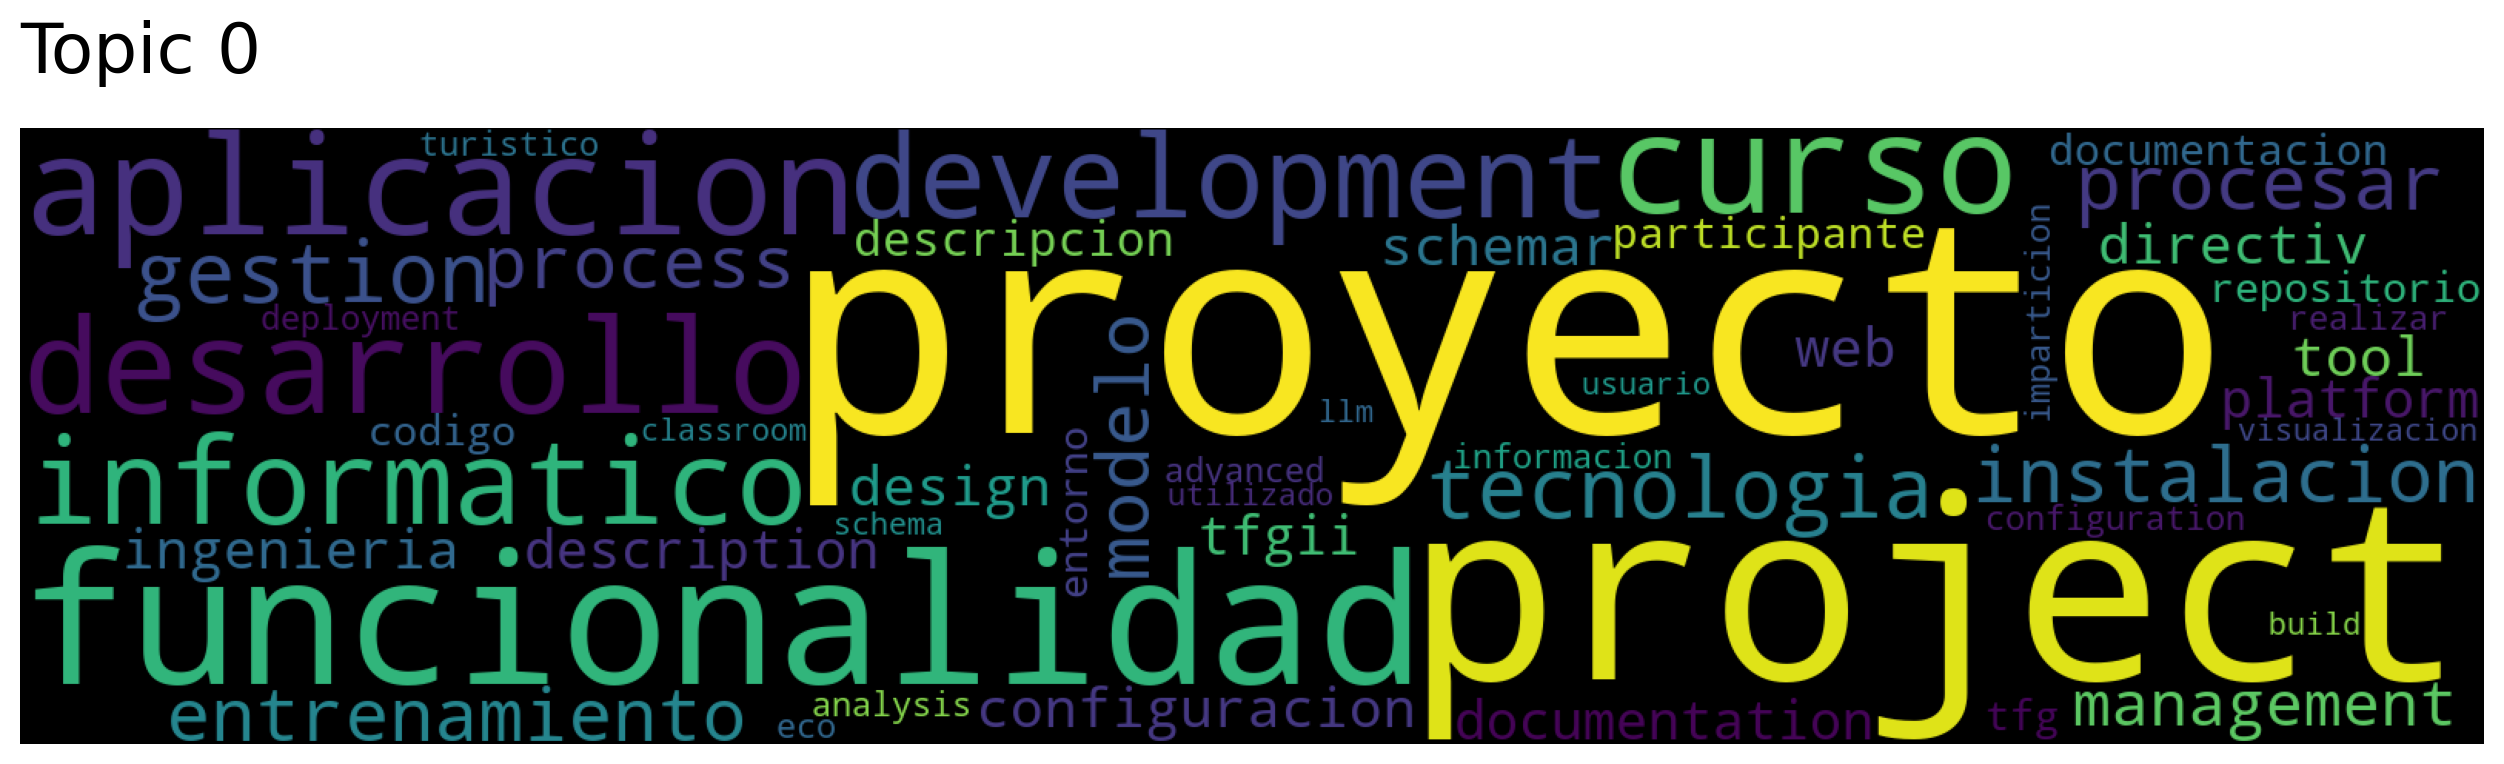

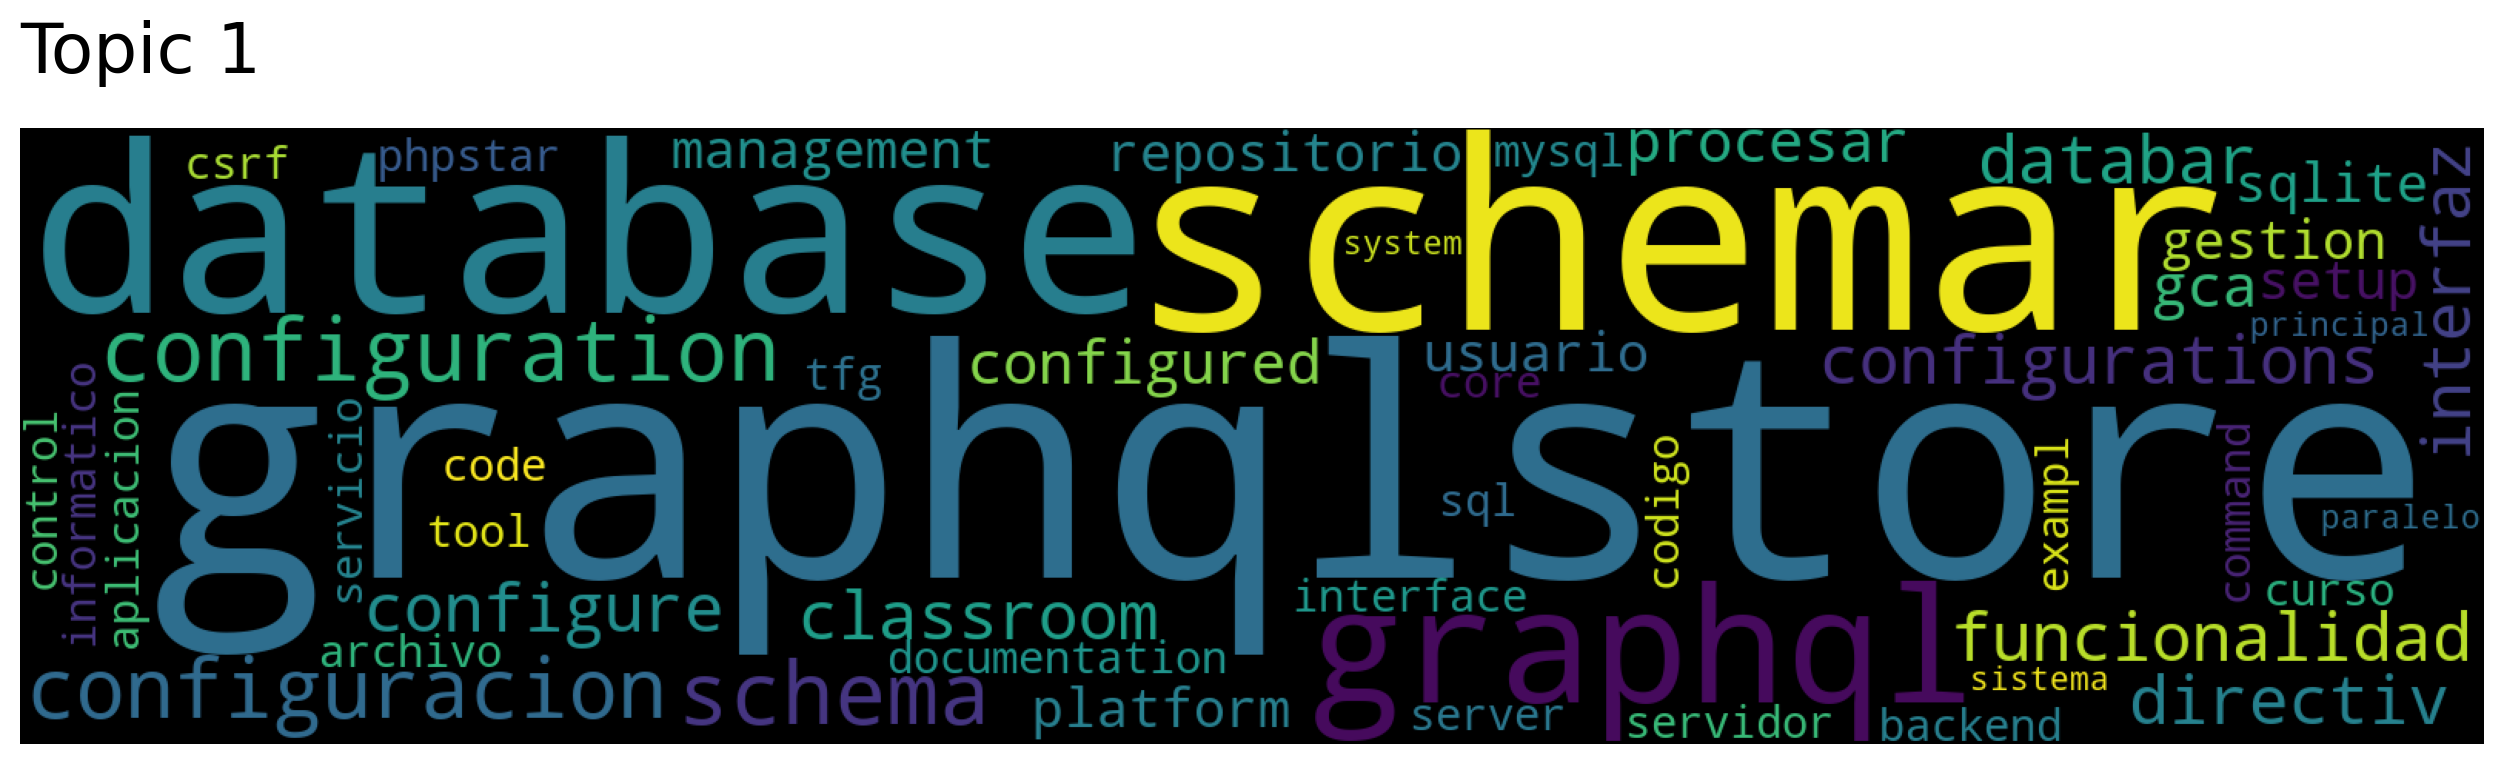

In [215]:
for topic in topic_nums:
    top2vec_model.generate_topic_wordcloud(topic)

In [216]:
def get_words(_model, _topic_num, num_words=5):
    topic_data = _model.get_topic(_topic_num)
    print(topic_data)

In [217]:
document_topics = top2vec_model.get_documents_topics(doc_ids=list(range(len(raw_documents))))

topic_nums = document_topics[0]
topic_scores = document_topics[1]
topic_words = document_topics[2]

display(topic_nums)
display(topic_scores)
print(topic_words)

array([0, 0, 1, 0, 1, 0, 0])

array([0.6850779 , 0.7837143 , 0.85359037, 0.76176393, 0.8535904 ,
       0.79524755, 0.7878474 ], dtype=float32)

[['proyecto' 'project' 'funcionalidad' 'aplicacion' 'curso' 'desarrollo'
  'informatico' 'development' 'tecnologia' 'gestion' 'instalacion'
  'procesar' 'entrenamiento' 'process' 'modelo' 'management'
  'configuracion' 'directiv' 'web' 'tool' 'design' 'ingenieria' 'schemar'
  'documentation' 'platform' 'description' 'tfgii' 'descripcion'
  'participante' 'documentacion' 'repositorio' 'codigo' 'tfg' 'entorno'
  'configuration' 'analysis' 'advanced' 'deployment' 'turistico'
  'imparticion' 'realizar' 'eco' 'informacion' 'visualizacion' 'llm'
  'usuario' 'build' 'utilizado' 'schema' 'classroom']
 ['proyecto' 'project' 'funcionalidad' 'aplicacion' 'curso' 'desarrollo'
  'informatico' 'development' 'tecnologia' 'gestion' 'instalacion'
  'procesar' 'entrenamiento' 'process' 'modelo' 'management'
  'configuracion' 'directiv' 'web' 'tool' 'design' 'ingenieria' 'schemar'
  'documentation' 'platform' 'description' 'tfgii' 'descripcion'
  'participante' 'documentacion' 'repositorio' 'codigo' 'tfg

In [218]:
top2vec_df_topics = pd.DataFrame({
    'documento_id': range(len(raw_documents)),
    'contenido_raw': raw_documents,
    'topico_asignado': topic_nums,
    'score_afinidad': topic_scores
})
top2vec_df_topics['palabras'] = [list(topic_words) for topic_words in topic_words]
display(top2vec_df_topics)

,documento_id,contenido_raw,topico_asignado,score_afinidad,palabras
0,0,# Eco City Tours\n\n## TFG Ingeniería Informát...,0,0.685078,"[proyecto, project, funcionalidad, aplicacion,..."
1,1,"<h1 align=""center""> 🏁 F1nalLap 🏎️ </h1>\n\n## ...",0,0.783714,"[proyecto, project, funcionalidad, aplicacion,..."
2,2,# GCA \n![license](https://img.shields.io/bad...,1,0.853590,"[graphqlstore, schemar, database, graphql, con..."
3,3,# Gestión de Formación\n\n![PHPUnit](https://g...,0,0.761764,"[proyecto, project, funcionalidad, aplicacion,..."
4,4,"[<p align=""center""><img src=""./graphqlstore.p...",1,0.853590,"[graphqlstore, schemar, database, graphql, con..."
5,5,# TFG - Desarrollo de una interfaz para planta...,0,0.795248,"[proyecto, project, funcionalidad, aplicacion,..."
6,6,# TFGII Modelo Cinemático Inverso de un robot ...,0,0.787847,"[proyecto, project, funcionalidad, aplicacion,..."


## BERTopic

In [219]:
from bertopic import BERTopic
import umap
import hdbscan

umap_model = umap.UMAP(n_neighbors=2, n_components=5, metric="cosine")
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=1)

bertopic_model = BERTopic(
    language="multilingual",
    embedding_model="all-MiniLM-L6-v2",  # rápido
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    verbose=True
)
topics, probs = bertopic_model.fit_transform(clean_text)

2025-10-23 15:56:53,007 - BERTopic - Embedding - Transforming documents to embeddings.
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2
Batches: 100%|██████████| 1/1 [00:00<00:00,  7.81it/s]
2025-10-23 15:56:54,934 - BERTopic - Embedding - Completed ✓
2025-10-23 15:56:54,934 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-10-23 15:56:54,945 - BERTopic - Dimensionality - Completed ✓
2025-10-23 15:56:54,946 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-10-23 15:56:54,947 - BERTopic - Cluster - Completed ✓
2025-10-23 15:56:54,949 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-10-23 15:56:54,957 - BERTopic - Representation - Completed ✓


In [220]:
print("Número de temas detectados:", len(set(topics)) - (1 if -1 in topics else 0))
print(f"Tópicos asignados: {topics}")

Número de temas detectados: 2
Tópicos asignados: [0, 0, 1, 0, 1, 0, 0]


In [221]:
# Obtener información de todos los tópicos
topic_info = bertopic_model.get_topic_info()
display(topic_info)

,Topic,Count,Name,Representation,Representative_Docs
0,0,5,0_proyecto_gestión_prueba_dato,"[proyecto, gestión, prueba, dato, edición, apl...",[tfgii modelo cinemático inverso robot gofo tf...
1,1,2,1_graphql_cli_source_relationship,"[graphql, cli, source, relationship, mysql, sc...",[gca gca centralized platform designed manage ...


In [222]:
for _, row in topic_info.iterrows():
    topic_num = row['Topic']
    count = row['Count']

    if topic_num != -1:  # Excluir outliers
        print(f"TÓPICO {topic_num} ({count} documentos):")
        # Obtener palabras clave específicas de este tópico
        topic_words = bertopic_model.get_topic(topic_num)
        palabras = [word for word, score in topic_words[:8]]  # Primeras 8 palabras
        print(f"{', '.join(palabras)}")

TÓPICO 0 (5 documentos):
proyecto, gestión, prueba, dato, edición, aplicación, tfg, fpisot
TÓPICO 1 (2 documentos):
graphql, cli, source, relationship, mysql, schema, command, doc


In [223]:
df_bertopic = pd.DataFrame({
    'documento_id': range(len(raw_documents)),
    'contenido_raw': raw_documents,
    'topico_numero': topics,
})

def get_word_topic(_topic_num):
    w = bertopic_model.get_topic(_topic_num)
    p = [_w for _w, score in w[:5]]  #solo primeras 5 palabras
    return ', '.join(p)

df_bertopic['palabras_clave'] = df_bertopic['topico_numero'].apply(get_word_topic)
display(df_bertopic)

,documento_id,contenido_raw,topico_numero,palabras_clave
0,0,# Eco City Tours\n\n## TFG Ingeniería Informát...,0,"proyecto, gestión, prueba, dato, edición"
1,1,"<h1 align=""center""> 🏁 F1nalLap 🏎️ </h1>\n\n## ...",0,"proyecto, gestión, prueba, dato, edición"
2,2,# GCA \n![license](https://img.shields.io/bad...,1,"graphql, cli, source, relationship, mysql"
3,3,# Gestión de Formación\n\n![PHPUnit](https://g...,0,"proyecto, gestión, prueba, dato, edición"
4,4,"[<p align=""center""><img src=""./graphqlstore.p...",1,"graphql, cli, source, relationship, mysql"
5,5,# TFG - Desarrollo de una interfaz para planta...,0,"proyecto, gestión, prueba, dato, edición"
6,6,# TFGII Modelo Cinemático Inverso de un robot ...,0,"proyecto, gestión, prueba, dato, edición"


## FASTopic


In [229]:

from fastopic import FASTopic
from topmost.preprocess import Preprocess

# Preprocess the dataset. This step tokenizes docs, removes stopwords, and sets max vocabulary size, etc.
# preprocess = Preprocess(vocab_size=your_vocab_size, tokenizer=your_tokenizer, stopwords=your_stopwords_set)
preprocess = Preprocess()
fast_model = FASTopic(num_topics=3, preprocess=preprocess)
top_words, doc_topic_dist = fast_model.fit_transform(clean_text)

INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2
parsing texts: 100%|██████████| 7/7 [00:00<00:00, 3498.17it/s]
2025-10-23 16:23:45,197 - TopMost - Real vocab size: 771
2025-10-23 16:23:45,197 - TopMost - Real training size: 7 	 avg length: 239.571
Training FASTopic: 100%|██████████| 200/200 [00:03<00:00, 58.86it/s]


In [283]:
print(top_words)

['fpisot ruta google contacto servicio firebar platform real temporada llm creer sostenible siguiente city eco', 'gofa entrenamiento formador mci flask entorno participante phpstar curso planta symfony phpunit correos sqlite fecha', 'graphql cli source relationship schema command doc sql field directivir database documentation conexion databar server']


In [287]:
#Cada fila de esta matriz representa un documento y cada columna representa un tópico
print(doc_topic_dist)

[[0.7519434  0.1460591  0.10199755]
 [0.68687224 0.13884522 0.17428255]
 [0.4698296  0.11203302 0.41813734]
 [0.14870101 0.7378585  0.11344053]
 [0.07422636 0.06761076 0.8581629 ]
 [0.1567409  0.48333487 0.35992417]
 [0.1422525  0.71830153 0.13944595]]


In [285]:
fig = fast_model.visualize_topic(top_n=10)
fig.show()

In [288]:
 # encuentra el índice del valor máximo en un array a lo largo de las columnas para cada fila
assigned_topic = np.argmax(doc_topic_dist, axis=1)

# te da la puntuación de ese tópico dominante
confianzas = np.max(doc_topic_dist, axis=1)

print(assigned_topic)
print(confianzas)

[0 0 0 1 2 1 1]
[0.7519434  0.68687224 0.4698296  0.7378585  0.8581629  0.48333487
 0.71830153]


In [292]:
fastopic_df = pd.DataFrame({
    'documento': range(len(clean_text)),
    'texto': clean_text,
    'tema': assigned_topic,
    'confianza': confianzas,
    'palabras_tema': [top_words[x] for x in assigned_topic]
})
display(fastopic_df)

,documento,texto,tema,confianza,palabras_tema
0,0,eco city tours tfg ingeniería informático fern...,0,0.751943,fpisot ruta google contacto servicio firebar p...
1,1,descripción bienvenido app web dedicado fórmul...,0,0.686872,fpisot ruta google contacto servicio firebar p...
2,2,gca gca centralized platform designed manage c...,0,0.469830,fpisot ruta google contacto servicio firebar p...
3,3,gestión formación introducción proyecto ser ap...,1,0.737858,gofa entrenamiento formador mci flask entorno ...
4,4,graphqlstore pypi version license ci cd usern...,2,0.858163,graphql cli source relationship schema command...
5,5,tfg desarrollo interfaz planta piloto trabajo ...,1,0.483335,gofa entrenamiento formador mci flask entorno ...
6,6,tfgii modelo cinemático inverso robot gofo tfg...,1,0.718302,gofa entrenamiento formador mci flask entorno ...
